# Preprocessing

* Code by Caroline Juang, c.juang@columbia.edu
* For Machine Learning for the Environmental Sciences, Columbia University
* Professor: Pierre Gentine
* November 2021 - December 2021

### Download Data

Downloading data from box is tricky, here's the URL for the data download.

Data are created by Park Williams, from various sources. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136851087076)

Fire data are created by Caroline Juang and Park Williams, from the Monitoring Trends in Burn Severity (MTBS) product and government agency databases. Use the `burnarea_combined.nc` file. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136850119129)

### Workspace Setup

**Import variables**

Just for technical use
* EPA ecoregion `epa_l2`
* western US region `mask_US`

Variable to predict
* forest burned area `burnarea`

Static
* fractional forest area `forest`
* elevation `elev`

Land cover change
* Distance to wildland-urban interface `wui_distance_new`
* Months since gridcell burned `return_months`
* Years since gridcell burned `return_years`

Climate (and z-variables which represent `observed` - `1984-2019 average`)
* daily maximum temperature `Tmax` `Tmax_z`
* vapor-pressure deficit `vpd` `vpd_z`
* relative humidity `rh` `rh_z`
* precipitation `prec` `prec_z`
* wind `wind`

**Initial investigations**
* create mask for the western US land
* Monthly and yearly fire return frequency (to get `return_months` and `return_years`)

In [1]:
# import
import numpy as np
import xarray as xr
import pandas as pd
import rioxarray as rio
import matplotlib.pyplot as plt

In [2]:
# importing data string
directory = 'C:\\Users\\carol\\Documents\\Research Data 2020\\12km\\'

### Ecoregions
* 10.1 Cold deserts
* 7.1 Marine west coast forest
* 11.1 Mediterranean California
* 9.4 South Central Semiarid Prairies
* 9.2 Temperate Prairies (not included)
* 13.1 Upper Gila Mountains
* 10.2 Warm Deserts
* 9.3 West-Central Semiarid Prairies
* 6.2 Western Cordillera
* 12.1 Western Sierra Madre Piedmont

In [3]:
## open the ecoregion data
ecoregion_data = xr.open_dataset(directory + 'landcover\\Ecoregions_EPA\\epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)

ecoregion_legend = ecoregion_data.ecoregion
print(ecoregion_legend.legend)
epa_l2 = ecoregion_data.epa_level2
ecoregion_data = None

1: COLD DESERTS, 2: MARINE WEST COAST FOREST, 3: MEDITERRANEAN CALIFORNIA, 4: SOUTH CENTRAL SEMIARID PRAIRIES, 5: TEMPERATE PRAIRIES, 6: UPPER GILA MOUNTAINS, 7: WARM DESERTS, 8: WEST-CENTRAL SEMIARID PRAIRIES, 9: WESTERN CORDILLERA, 10: WESTERN SIERRA MADRE PIEDMONT


In [4]:
# setup forested area burned

firsttime = "1984-01-15"
finaltime = "2019-12-15"

# forest fractional area (Ruefenacht et al., 2018)
forest_type_data = xr.open_dataset(directory + 'landcover\\US_ForestType_Ruefenacht\\forest_type_frac.nc')

# fire burned area (Williams and Juang)
burnarea_data = xr.open_dataset(directory + 'wildfire\\burnarea_combined.nc', engine='netcdf4')
time_str = burnarea_data.time
X = burnarea_data.X
Y = burnarea_data.Y
burnarea_data = burnarea_data.rio.set_spatial_dims(x_dim='X', y_dim='Y', inplace=True)
burn = burnarea_data.burnarea

# get forest burned area (forest fraction x burned area)

# storage
forest = np.zeros((len(Y), len(X)), np.single)
# add up the forest percentages for each forest type
forest = forest_type_data.sum(dim='ftype').forest_type_frac
burnarea = burn*forest.values # result

# constrain time to 2019 (last year of fully-known data)
burnarea = burnarea.loc[firsttime:finaltime]

In [5]:
# import and setup other data

# CLIMATE

ea = xr.open_dataset(directory + 'climate\\primary\\ea.nc')
es = xr.open_dataset(directory + 'climate\\primary\\es.nc')
vpd = es.es.loc[firsttime:finaltime] - ea.ea.loc[firsttime:finaltime]

rh = xr.open_dataset(directory + 'climate\\primary\\rh.nc')
rh = rh.rh.loc[firsttime:finaltime]

tmax = xr.open_dataset(directory + 'climate\\primary\\tmax.nc')
tmax = tmax.tmax.loc[firsttime:finaltime]

prec = xr.open_dataset(directory + 'climate\\primary\\prec.nc')
prec = prec.prec.loc[firsttime:finaltime]

wind = xr.open_dataset(directory + 'climate\\primary\\wind.nc')
wind = wind.wind.loc[firsttime:finaltime]

# LAND COVER

elevstd = xr.open_dataset(directory + 'topography\\elevstd.nc')
elevstd = elevstd.elevstd

wui_distance = xr.open_dataset(directory + 'population\\silvis\\wui_distance.nc')
wui_distance = wui_distance.wui_distance

In [6]:
time = burnarea.time
province = epa_l2.province

for thisregion in province:
    # vpd
    tmpavg = (vpd*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
    vpd_z = vpd*epa_l2[thisregion] - tmpavg
    
    # rh
    tmpavg = (rh*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
    rh_z = rh*epa_l2[thisregion] - tmpavg
    
    # tmax
    tmpavg = (tmax*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
    tmax_z = tmax*epa_l2[thisregion] - tmpavg
    
    # prec
    tmpavg = (prec*epa_l2[thisregion]).sum(dim=['Y','X','time']) / (epa_l2[thisregion].sum()*len(time))
    prec_z = tmax*epa_l2[thisregion] - tmpavg

In [7]:
# convert wui distance into variable for all years

# get time and set up
firstyear = pd.DatetimeIndex(burnarea.time.values).year.min()
finalyear = pd.DatetimeIndex(burnarea.time.values).year.max()
years = np.arange(firstyear, finalyear+1, 1)

wui_distance_new = wui_distance.interp(year=years) # interpolate to fill in years

# Initial investigations

Some interesting ways to look at fire return rate

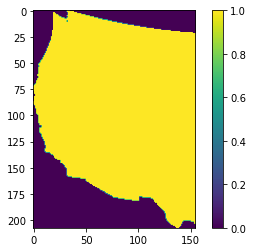

In [8]:
# storage
time = burnarea.time
X = burnarea_data.X
Y = burnarea_data.Y

# get the NaN values in a mask
maskUS = ~np.isnan(burnarea.isel(time=0))
fig, ax = plt.subplots()
this = ax.imshow(maskUS)
fig.colorbar(this)

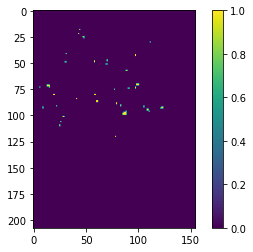

In [9]:
burnyes_month = (burnarea>0).astype(int)

fig, ax = plt.subplots()
this = ax.imshow(burnyes_month.sel(time="2018-09-15"))
fig.colorbar(this)

In [10]:
burnyes_month.where((burnyes_month!=1) & (burnyes_month!=0)).count()

<xarray.DataArray 'burnarea' ()>
array(0)

In [11]:
# burnno_yr captures conditionally whether a gridcell burned. 
# 1 = gricell did not burn
# 0 = gricell burned
burnno_yr = burnarea.resample(indexer={'time':'Y'}).sum(skipna=True)
burnno_yr = (burnno_yr==0).astype(int)

# extract dimension info
time = burnno_yr.time
X = burnno_yr.X
Y = burnno_yr.Y

# initialize storage
return_years = np.zeros((len(time), len(Y), len(X))) # empty storage for years since the last fire

# iterate
index = 1
for year in burnno_yr.time[index:]:
    tmp_thisyr = burnno_yr.isel(time=index) # 2d DataArray
    tmp_prevyr = return_years[index-1] # last year's burn info
    tmp_return = tmp_thisyr + tmp_prevyr # add new year
    tmp_return = tmp_return.where(tmp_thisyr>0, other=0) # if a fire burned, reset the counter with 0
    return_years[index] = tmp_return # store this memory
    index+=1

# transform return_years into a xarray DataArray
return_years = xr.DataArray(data=return_years,
                            dims=['time','Y','X'],
                            coords=dict(X=X, Y=Y, time=time),
                            attrs=dict(
                                description='Time since gridcell last burned',
                                units='years'
                            ))
return_years = return_years.where(maskUS) # put NaN outside western US border

Text(0, 0.5, 'Number of gridcells')

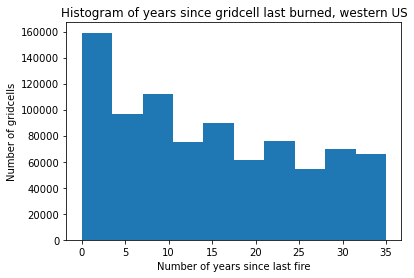

In [12]:
fig, ax = plt.subplots()
ax.hist(np.ndarray.flatten(return_years.values))
ax.set_title('Histogram of years since gridcell last burned, western US')
ax.set_xlabel('Number of years since last fire')
ax.set_ylabel('Number of gridcells')

In [13]:
# burnno_mo captures conditionally how many months since the last time the gridcell burned.
# 1 = gricell did not burn
# 0 = gricell burned
burnno_mo = (burnarea==0).astype(int)

# extract dimension info
time = burnno_mo.time
X = burnno_mo.X
Y = burnno_mo.Y

# initialize storage
return_months = np.zeros((len(time), len(Y), len(X))) # empty storage for years since the last fire

# iterate
index = 1
for year in burnno_mo.time[index:]:
    tmp_thismo = burnno_mo.isel(time=index) # 2d DataArray
    tmp_prevmo = return_months[index-1] # last year's burn info
    tmp_return = tmp_thismo + tmp_prevmo # add new year
    tmp_return = tmp_return.where(tmp_thisyr>0, other=0) # if a fire burned, reset the counter with 0
    return_months[index] = tmp_return # store this memory
    index+=1

# transform into a xarray DataArray
return_months = xr.DataArray(data=return_months,
                            dims=['time','Y','X'],
                            coords=dict(X=X, Y=Y, time=time),
                            attrs=dict(
                                description='Time since gridcell last burned',
                                units='months'
                            ))
return_months = return_months.where(maskUS) # put NaN outside western US border

Text(0, 0.5, 'Number of gridcells')

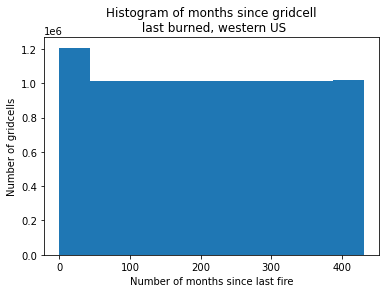

In [14]:
fig, ax = plt.subplots()
ax.hist(np.ndarray.flatten(return_months.values))
ax.set_title('Histogram of months since gridcell\n last burned, western US')
ax.set_xlabel('Number of months since last fire')
ax.set_ylabel('Number of gridcells')

In [18]:
# export all data as new netCDF files

epa_l2.to_netcdf('data\\epa_l2.nc') # static
maskUS.to_netcdf('data\\maskUS.nc')
forest.to_netcdf('data\\forest.nc')
elevstd.to_netcdf('data\\elevstd.nc')

vpd.to_netcdf('data\\vpd.nc') # climate
rh.to_netcdf('data\\rh.nc')
tmax.to_netcdf('data\\tmax.nc')
prec.to_netcdf('data\\prec.nc')
wind.to_netcdf('data\\wind.nc')
vpd_z.to_netcdf('data\\vpd_z.nc')
rh_z.to_netcdf('data\\rh_z.nc')
tmax_z.to_netcdf('data\\tmax_z.nc')
prec_z.to_netcdf('data\\prec_z.nc')

burnarea.to_netcdf('data\\burnarea.nc') # y variable to predict
wui_distance_new.to_netcdf('data\\wui_distance_new.nc') # land change
return_years.to_netcdf('data\\return_years.nc')
return_months.to_netcdf('data\\return_months.nc')